In [94]:
import pandas as pd
import igraph as ig
from ease import EASE
import seaborn as sns
import numpy as np
import pickle
import multiprocessing
import itertools as it
import math

path = './files/'

In [ ]:
dd

In [30]:
# load gene set dictionaries - msigdb
def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return pickle.load(file=pickle_file)
    
msigdb_c6_dict = open_pickle('msigdb_c6_all_dict.pkl')
misgdb_c2_cgp_dict = open_pickle('msigdb_c2_cgp_dict.pkl')
misgdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')


In [34]:
# get network data with pd
regulome_network_edges = pd.read_csv(filepath_or_buffer='./files/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_network_graph = ig.Graph.DataFrame(regulome_network_edges, directed=True, use_vids = False)
regulome_network_graph_undirected = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids = False)

In [135]:
# Investigate Leiden resolution - joblib, dask
std_output = pd.DataFrame({
    'pathway_id': ['---'],
    'Overlap': [0],
    'Pvalue': [1],
    'FDR': [1],
    'FWER': [1] 
})
cov = 4000 # what should I set this to??

def cluster_leiden(graph, res, b=0.01, n_iter=3):
    return graph.community_leiden(objective_function='modularity',
                                weights='PPV',
                                resolution=res,
                                beta=b,
                                n_iterations=n_iter) # only few small clusters and 1 large one

def cluster_louvain(graph, res):
    return graph.community_multilevel(weights='PPV',
                                    return_levels=False,
                                    resolution=res)


cluster_enrichment_dict = dict() # output is a dictionary (resolution) of tuple with dictionary (per cluster) containing tuple with a pandas df (containing enrichment fr each pathway)

def set_enrichment(res, beta, gene_set):
    print(f"Reslution: {res}, beta {beta}")
    clusters = cluster_leiden(regulome_network_graph_undirected, res=res, b=beta)

    enrichment_dict = dict()
    for (cluster_n, cluster) in enumerate(clusters.subgraphs()):
        query = cluster.vs['name']
        if (len(query) > 2000) or (len(query) < 3):
            continue
        enrichment = EASE(query_set=query, genesets=gene_set, PT=cov)
        enrichment_dict[cluster_n] = (enrichment, len(query), query) # maybe save this as a namedtuple with enrihcment and subgraph
    return res, beta, enrichment_dict, len(enrichment_dict)

# collect_enrichment(set_enrichment(2))
def collect_enrichment(enrichment):
 # pool returns values in a list, therefore Have tuple in a list and have to extract
    cluster_enrichment_dict.setdefault(enrichment[0], dict())[enrichment[1]] = enrichment[2:]
    # print("Collected")

def error_function(e):
    print(f"Error, could not compute {e}")

beta_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
res_range = np.arange(2, 15, 1)
num_processes = 3
with multiprocessing.Pool(num_processes) as pool:
    pool = multiprocessing.Pool(num_processes)
    for res, beta in it.product(res_range, beta_range):
        pool.apply_async(func=set_enrichment, args=(res,beta, misgdb_c3_tft_dict), callback=collect_enrichment, error_callback=error_function)
    pool.close()
    pool.join()

Reslution: 2, beta 0.01
Reslution: 2, beta 0.05
Reslution: 2, beta 0.1
Reslution: 2, beta 0.5
Collected
Reslution: 3, beta 0.01
Collected
Reslution: 3, beta 0.05
Collected
Reslution: 3, beta 0.1
Collected
Reslution: 3, beta 0.5
Collected
Reslution: 4, beta 0.01
Collected
Reslution: 4, beta 0.05
Collected
Reslution: 4, beta 0.1
Collected
Reslution: 4, beta 0.5
Collected
Reslution: 5, beta 0.01
Collected
Reslution: 5, beta 0.05
Collected
Reslution: 5, beta 0.1
Collected
Reslution: 5, beta 0.5
Collected
Reslution: 6, beta 0.01
Collected
Reslution: 6, beta 0.05
Collected
Reslution: 6, beta 0.1
Collected
Reslution: 6, beta 0.5
Collected
Reslution: 7, beta 0.01
Collected
Reslution: 7, beta 0.05
Collected
Reslution: 7, beta 0.1
Collected
Reslution: 7, beta 0.5
Collected
Reslution: 8, beta 0.01
Collected
Reslution: 8, beta 0.05
Collected
Reslution: 8, beta 0.1
Collected
Reslution: 8, beta 0.5
Collected
Reslution: 9, beta 0.01
Collected
Reslution: 9, beta 0.05
Collected
Reslution: 9, beta 0.1
C

In [136]:
# save to pickle
filename = 'f'
with open(path+f'clustering_results/{filename}', 'wb') as file:
    pickle.dump(cluster_enrichment_dict, file=file)

In [208]:
threshold = 0.05

distributions_df_filt = pd.DataFrame()
for (res, betas) in cluster_enrichment_dict.items():
    for (beta, cluster_enrichments) in betas.items():
        cluster_sizes = [float(math.log(cluster[1], 10)) for cluster in cluster_enrichments[0].values() if (cluster[0]['FDR'] < threshold).any()]
        n_clusters = len(cluster_sizes)
        distributions_df_filt = pd.concat([distributions_df_filt, pd.DataFrame({'size': cluster_sizes, 'resolution':[res]*n_clusters, 'beta': [beta]*n_clusters})])


distributions_df = pd.DataFrame()
for (res, betas) in cluster_enrichment_dict.items():
    for (beta, cluster_enrichments) in betas.items():
        n_clusters = cluster_enrichments[1]
        cluster_sizes = [float(math.log(cluster[1], 10)) for cluster in cluster_enrichments[0].values()]
        distributions_df = pd.concat([distributions_df, pd.DataFrame({'size': cluster_sizes, 'resolution':[res]*n_clusters, 'beta': [beta]*n_clusters})])

In [209]:
len(distributions_df_filt)

515

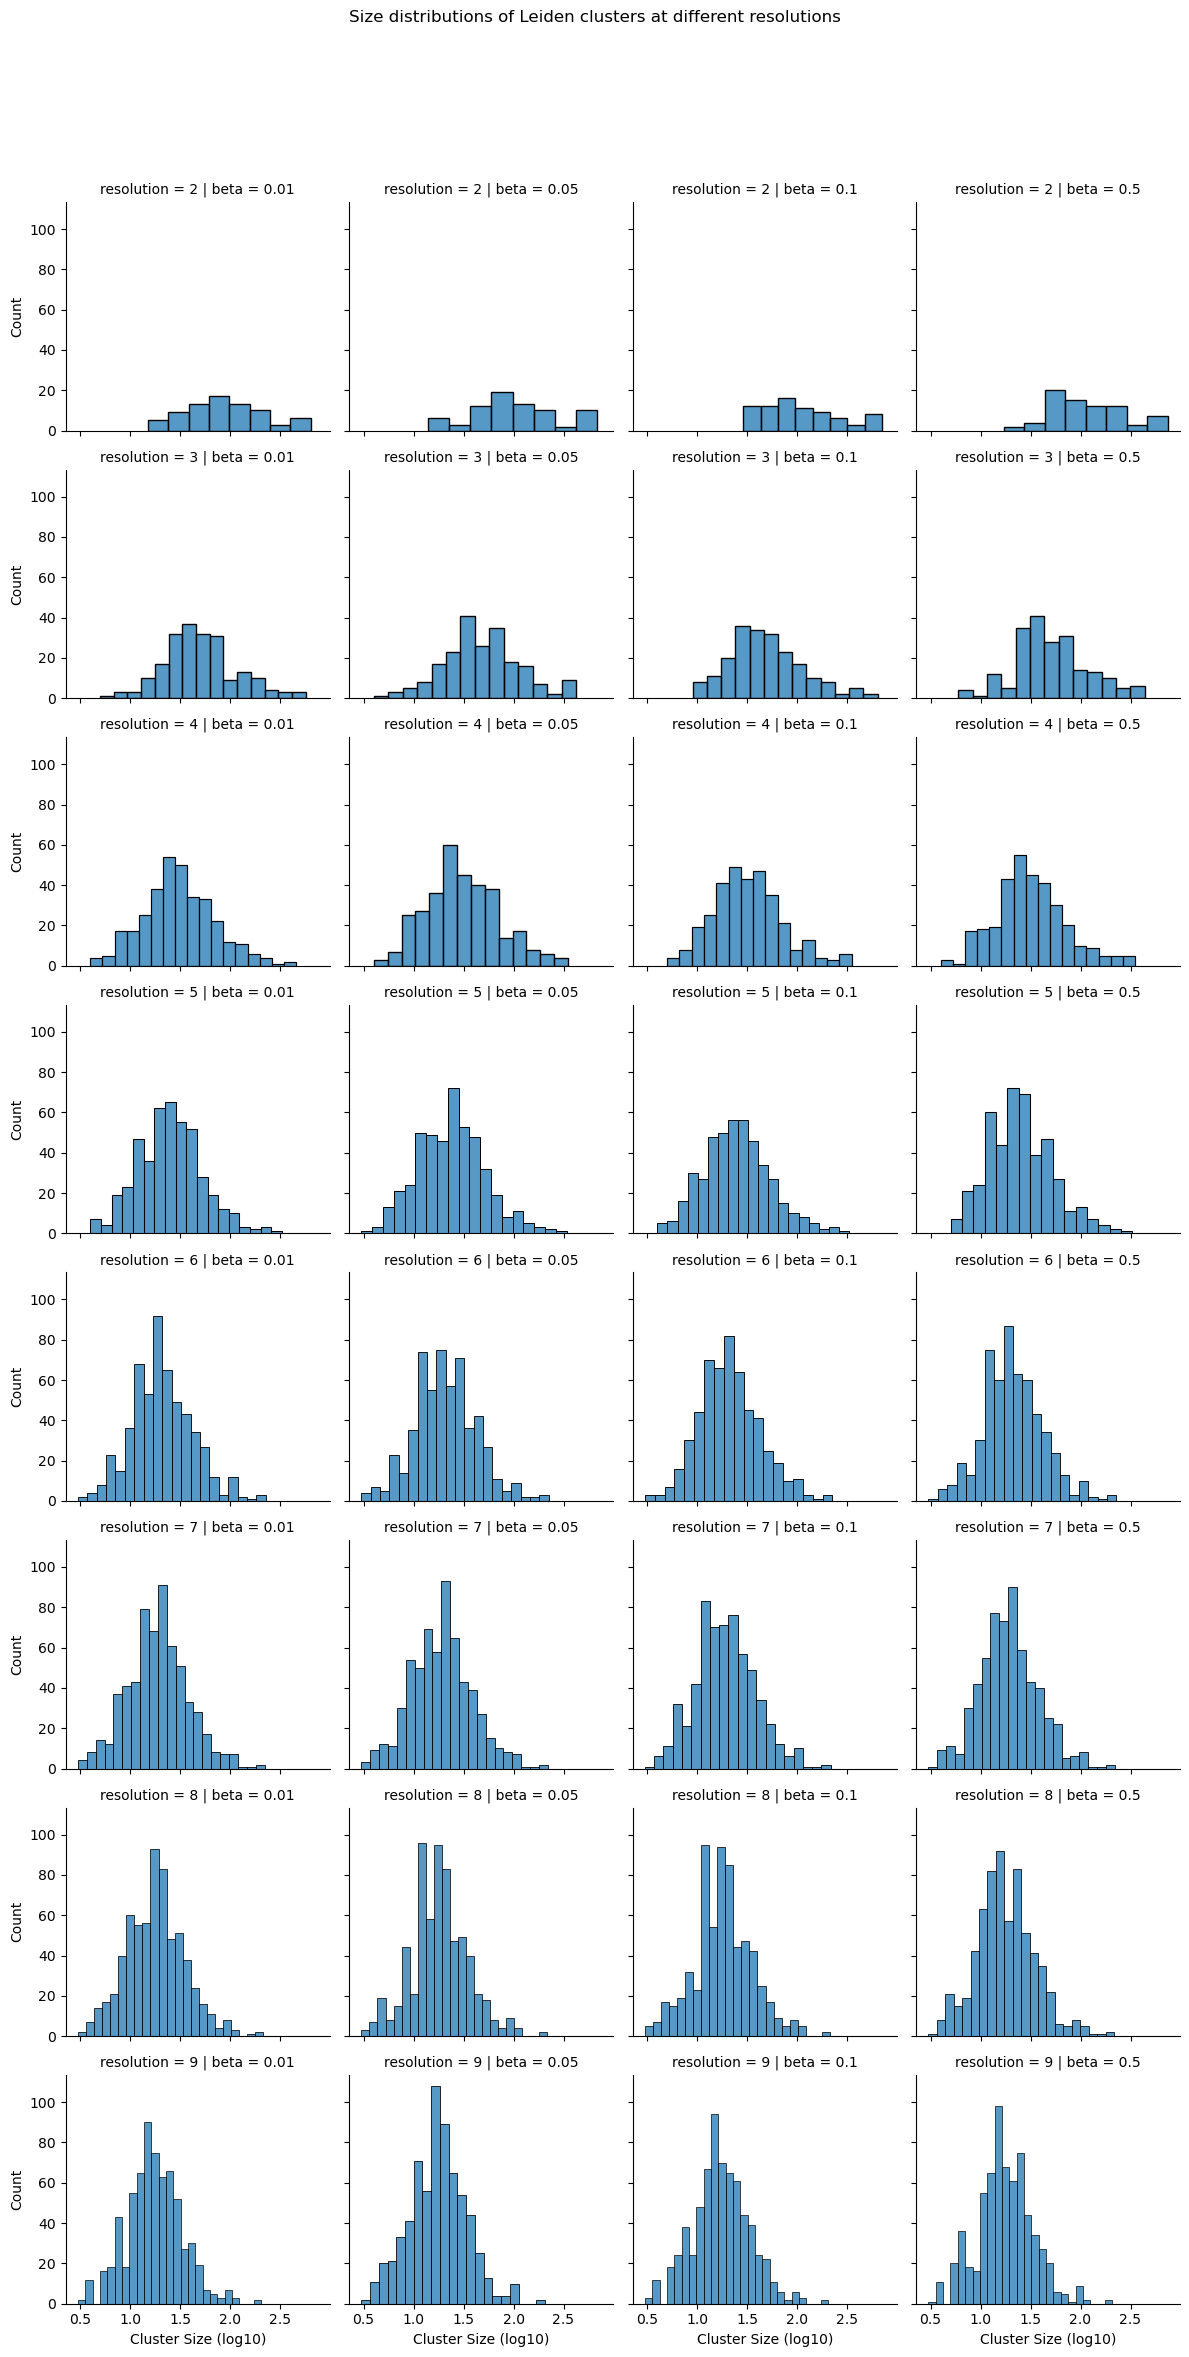

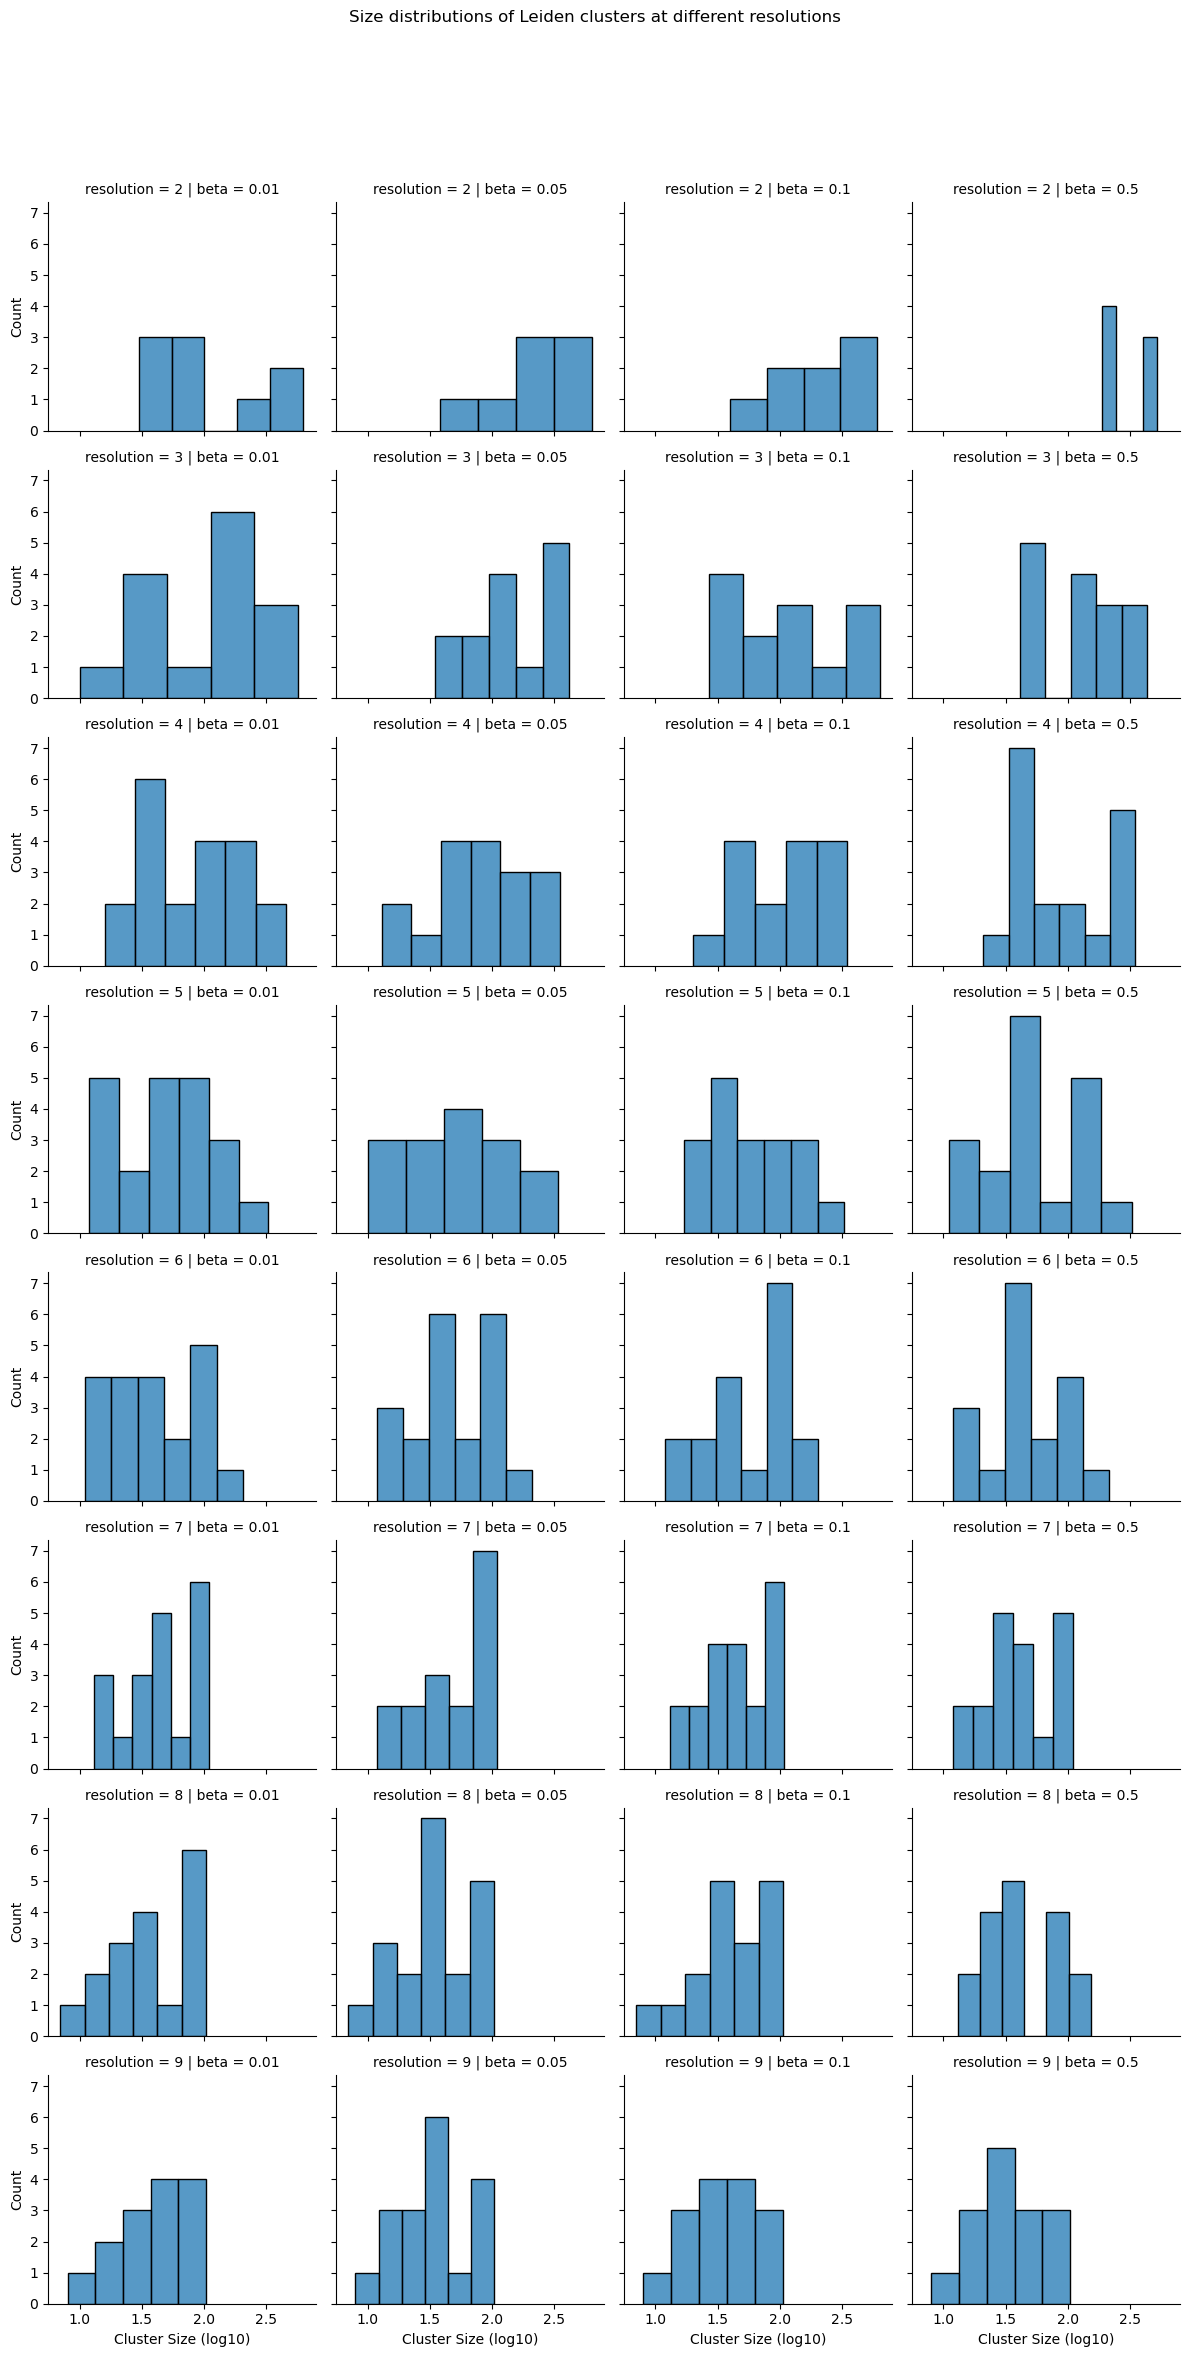

In [200]:
fig1 = sns.FacetGrid(distributions_df, row='resolution',col='beta')
fig1.map(sns.histplot, 'size')
fig1.figure.suptitle("Size distributions of Leiden clusters at different resolutions")
fig1.figure.subplots_adjust(top=0.9)
fig1.set_xlabels('Cluster Size (log10)')

fig2 = sns.FacetGrid(distributions_df_filt, row='resolution',col='beta')
fig2.map(sns.histplot, 'size')
fig2.figure.suptitle("Size distributions of Leiden clusters at different resolutions")
fig2.figure.subplots_adjust(top=0.9)
fig2.set_xlabels('Cluster Size (log10)')

#fig.savefig('./images/grid_leiden_2_5_001_05_msigdbcgp.png')

1910.9999999999984
0.0


(0.0, 100.0)

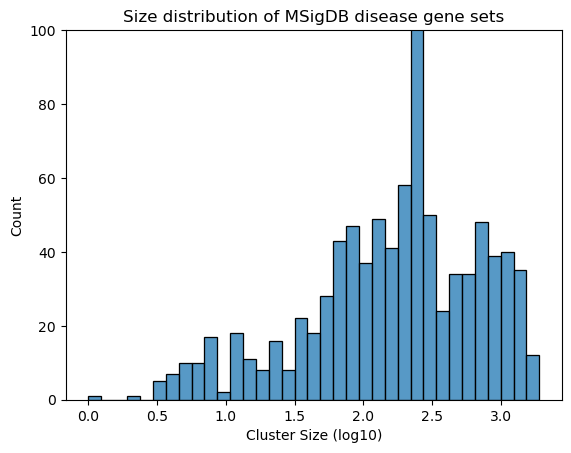

In [165]:
set_sizes = [math.log(len(gene_set), 10) for gene_set in misgdb_c3_tft_dict.values() if len(gene_set) != 0] 
print(float(10)**max(set_sizes))
print(min(set_sizes))
fig = sns.histplot(set_sizes)
fig.set_title("Size distribution of MSigDB disease gene sets")
fig.get_figure().savefig("helloo.png")
fig.set_xlabel("Cluster Size (log10)")
fig.set_ylim([0, 100])

In [146]:
with open(path+"clustering_results/leiden_2_10_001_05_msigdb_tft.pkl", 'rb') as file:
    cluster_enrichment_dict = pickle.load(file=file, encoding='infer')

In [163]:
CCS_dict = dict()
threshold = 0.01

for (res, betas) in cluster_enrichment_dict.items():
    cluster_enrichments = betas[0.01]
    enrichment_dict = cluster_enrichments[0]
    enriched_list = list()
    n_clusters = 0
    # n_clusters = cluster_enrichments[1] # number of appropriately sized clusters, filtered before EASE
    for cluster_num, enrichment in enrichment_dict.items():
        # filter the cluster sizes
        # if enrichment[1] >
        enrichment = enrichment[0]
        enriched = enrichment[enrichment.FDR < threshold]
        if len(enriched) != 0:
            enriched_list.append(enriched)
            n_clusters += 1

    if len(enriched_list) == 0:
        CCS_dict[res] = (pd.DataFrame({'pathway_id': [],
                                                'Overlap': [],
                                                'Pvalue': [],
                                                'FDR': [],
                                                'FWER': []}), 0)
        continue
    # !!!!! SAVE ALSO THE NUMBER OF THE CLUSTER FOR LATER RETIEVAL OF THE QUERY
    enriched_df = pd.concat(enriched_list)
    path_per_cluster = len(enriched_df)/n_clusters
    cluster_per_path = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
    CCS = path_per_cluster/cluster_per_path

    CCS_dict[res] = (enriched_df, CCS)

627
109
205
100
59
85
185
573
53
63
492
23
56
87
83
30
26
105
79
106
136
143
40
26
18
228
148
130
494
53
113
234
54
257
73
63
28
429
163
393
275
642
134
72
204
248
118
77
76
239
96
27
138
162
37
130
82
64
41
37
71
54
37
60
65
74
49
41
179
35
17
47
46
82
15
23
411
22
159
212
15
430
28
21
37
380
37
33
8
54
39
16
72
34
30
571
42
76
48
82
71
40
175
10
81
57
67
71
66
22
36
28
154
340
22
59
131
39
193
29
64
148
80
83
36
28
144
25
184
113
49
165
66
50
27
35
17
58
49
20
122
35
177
39
24
229
28
34
11
27
259
131
16
72
103
68
39
172
26
137
41
81
30
42
27
93
77
88
27
45
65
8
33
429
181
16
120
56
31
250
230
68
211
9
64
70
28
59
33
109
51
41
57
79
109
209
45
23
35
24
89
14
80
97
49
50
59
50
27
52
36
48
82
26
45
16
108
18
35
13
15
31
44
28
27
75
32
50
36
56
39
135
72
16
21
50
66
59
62
50
40
45
49
45
35
78
52
55
72
27
124
70
46
51
40
37
48
29
19
56
20
21
34
20
72
26
36
159
73
41
32
33
36
33
33
60
5
21
21
160
22
37
10
28
100
103
137
190
13
348
12
10
40
325
20
57
13
14
28
130
23
74
40
27
16
456
16
30
22

<Axes: >

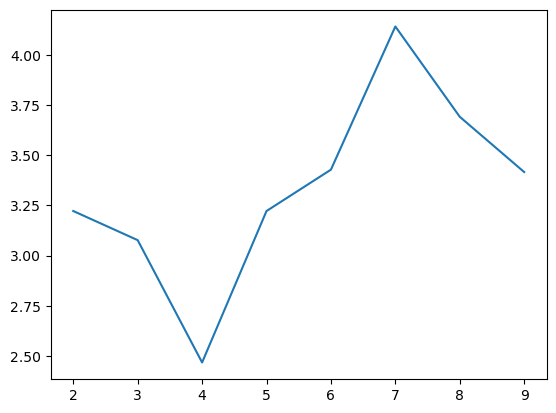

In [156]:
CCS_list = [CCS[1] for CCS in CCS_dict.values()]
resolutions = CCS_dict.keys()

sns.lineplot(x=resolutions, y=CCS_list)

In [ ]:
num_pathways = list()
for res, hits in CCS_dict.items():
    num_pathways.append(len(hits[0].pathway_id.unique()))
num_pathways
 
plot = sns.lineplot(x=resolutions, y=num_pathways)
plot.set_title("Number of enriched pathwys per resolution in Louvain")
plot.set_xlim([0,10])


In [ ]:
n_clusters = [n[1] for n in cluster_enrichments.values()]

sns.lineplot(x=n_clusters, y=num_pathways)

In [ ]:
infomap_clusters = regulome_network_graph.community_infomap(edge_weights='5:PPV', trials=10) # generaetd some small clusters and 1 large one

In [ ]:


leiden_clusters = regulome_network_graph_undirected.community_leiden(objective_function='modularity',
                                                          weights='5:PPV',
                                                          resolution=12.0,
                                                          beta=0.01,
                                                          n_iterations=3) # only few small clusters and 1 large one

In [ ]:
# non-overlapping   

louvain_clusters = regulome_network_graph_undirected.community_multilevel(weights='PPV',
                                                                          return_levels=False,
                                                                          resolution=5)